<br>
<center>
<h1>Workforce Analytics</h1>
<h2><i> - Seongmin Lee(CID: 01247436)  -</i></h2>

# Preprocessing & Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import requests
import re
import sys
import io
import time
import math
from collections import Counter
import datetime
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

In [3]:
# Base dataset
WOS_df = pd.read_pickle('./data/WOS_scraped_df.pkl')
WOS_df.head(2)

,WOS_URL,Title,co_author1,co_author2,journal_type,research_areas,WOS_cate,address,organization,date,cited_time,num_of_ref,abstract,keywords,publisher
0,http://gateway.webofknowledge.com/gateway/Gate...,Nelson-Plosser revisited: The ACF approach,"[abadir, km, caggiano, g, talmain, g]","[Abadir, Karim M, Caggiano, Giovanni, Talmain,...",JOURNAL OF ECONOMETRICS,"[Business & Economics, Mathematics, Mathemat...","[Economics, Mathematics, Interdisciplinary Ap...","[Univ Glasgow, Glasgow G QQ, Lanark, Scotland,...","[Imperial College London, University of Glasgo...",13-Jul,5,42,We detect a new stylized fact that is common t...,"[MACROECONOMIC TIME-SERIES, LONG-MEMORY, STOCK...","ELSEVIER SCIENCE SA, PO BOX 564, 1001 LAUSANNE..."
1,http://gateway.webofknowledge.com/gateway/Gate...,An I(d) model with trend and cycles,"[abadir, km, distaso, w, giraitis, l]","[Abadir, Karim M, Distaso, Walter, Giraitis, L...",JOURNAL OF ECONOMETRICS,"[Business & Economics, Mathematics, Mathemat...","[Economics, Mathematics, Interdisciplinary Ap...","[Univ London, Dept Econ, London E NS, England,...","[Imperial College London, University of London]",11-Aug,5,22,This paper deals with models allowing for tren...,"[LONG-RANGE DEPENDENCE, MEMORY STATIONARY ERRO...","ELSEVIER SCIENCE SA, PO BOX 564, 1001 LAUSANNE..."


In [4]:
WOS_df.shape

(1421, 15)

## 1. Year since published

In [5]:
# Call datetime class to now
now = datetime.datetime.now()

# By using regex, extract the numbers related to years
number_only = [''.join(re.findall(r'\d+', j)) for j in WOS_df.date]
year_only = [i[-2:] for i in number_only]

year_list = []
for y in year_only:
    if int(y) > int(str(now.year)[2:4]): # greater than 18
        year_list.append('19' + y)
    else:
        year_list.append('20'+ y)
WOS_df['published_yrs'] = year_list
WOS_df['yrs_since_published'] = [now.year - int(y) + 1 for y in year_list]
WOS_df['citation_per_yr'] = WOS_df['cited_time']/WOS_df['yrs_since_published']

In [6]:
WOS_df[['Title', 'cited_time', 'citation_per_yr', 'yrs_since_published', 'published_yrs']].head(5)

,Title,cited_time,citation_per_yr,yrs_since_published,published_yrs
0,Nelson-Plosser revisited: The ACF approach,5,0.833333,6,2013
1,An I(d) model with trend and cycles,5,0.625000,8,2011
2,Two estimators of the long-run variance: Beyon...,9,0.900000,10,2009
3,Testing joint hypotheses when one of the alter...,24,2.000000,12,2007
4,Nonstationarity-extended local Whittle estimation,81,6.750000,12,2007


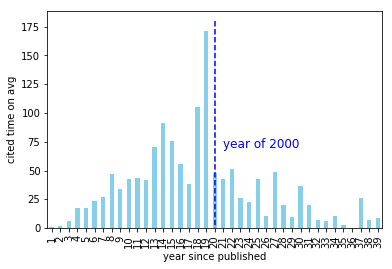

In [41]:
# Plot cited time on average by the period after being published
WOS_df.groupby('yrs_since_published').mean()['cited_time'].plot(kind = 'bar', color = 'skyblue')
plt.xlabel('year since published')
plt.ylabel('cited time on avg')
plt.vlines(x = 19, ymin = 180, ymax = 0, linestyles = '--', color = 'blue')
plt.annotate('year of 2000', xy = (20, 70), fontsize = 12, color = 'blue')
plt.savefig('./graph/image1', bbox_inches='tight')
plt.show()

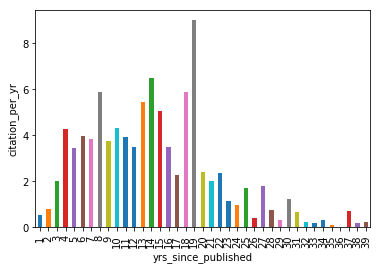

In [8]:
# Plot cited time on average by the period after being published
WOS_df.groupby('yrs_since_published').mean()['citation_per_yr'].plot(kind = 'bar')
plt.ylabel('citation_per_yr')
plt.show()

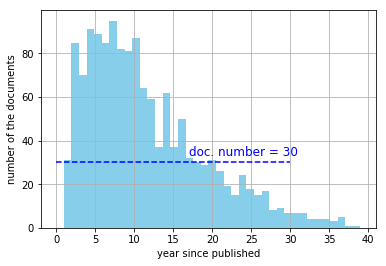

In [43]:
WOS_df['yrs_since_published'].hist(bins = 39, color = 'skyblue')
plt.hlines(y = 30, xmin = 0, xmax = 30, linestyles = '--', color = 'blue')
plt.ylabel('number of the documents')
plt.xlabel('year since published')
plt.annotate('doc. number = 30', xy = (17, 33), fontsize = 12, color = 'blue')
plt.savefig('./graph/image2', bbox_inches='tight')
plt.show()


In [44]:
WOS_df.shape

(1421, 18)

In [45]:
WOS_df = WOS_df[WOS_df['yrs_since_published'] <= 20]

In [46]:
WOS_df.shape

(1227, 18)

## 2. Organization Country

In [47]:
#Get the country name from the address column.
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

address_list = []
for i in list(WOS_df.address):
    add_unit = []
    for j in i:
        if 'USA' in j.split(',')[-1].strip().upper(): # MA USA -> USA
            add_unit.append('USA')
        elif j.split(',')[-1].strip().upper() in states:
            add_unit.append('USA')
        elif 'CHINA' in j.split(',')[-1].strip().upper(): # Peoples R China -> China
            add_unit.append('CHINA')
        else:
            add_unit.append(j.split(',')[-1].strip().upper()) 
    if len(add_unit) == 0:
        address_list.append(['ENGLAND'])
    else:
        address_list.append(list(add_unit))
        
WOS_df['organ_country'] = address_list

In [48]:
WOS_df[['Title', 'cited_time', 'address', 'organ_country']].head(5)

,Title,cited_time,address,organ_country
0,Nelson-Plosser revisited: The ACF approach,5,"[Univ Glasgow, Glasgow G QQ, Lanark, Scotland,...","[SCOTLAND, ENGLAND, ENGLAND, ITALY]"
1,An I(d) model with trend and cycles,5,"[Univ London, Dept Econ, London E NS, England,...","[ENGLAND, ENGLAND]"
2,Two estimators of the long-run variance: Beyon...,9,"[Univ London, Dept Econ, London E NS, England,...","[ENGLAND, ENGLAND]"
3,Testing joint hypotheses when one of the alter...,24,"[Univ London Imperial Coll Sci Technol Med, L...",[ENGLAND]
4,Nonstationarity-extended local Whittle estimation,81,"[Univ London Imperial Coll Sci Technol Med, T...","[ENGLAND, ENGLAND]"


## 3. Authors

### The number of the authors for each publication

In [49]:
# The number of the authors for each publication
WOS_df['co_author_num'] = WOS_df['co_author1'].apply(lambda x:len(x))

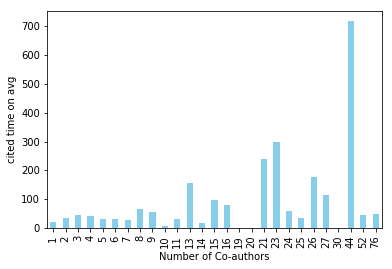

In [225]:
WOS_df.groupby('co_author_num').mean()['cited_time'].plot(kind = 'bar', color = 'skyblue')
plt.xlabel('Number of Co-authors')
plt.ylabel('cited time on avg')
plt.savefig('./graph/image3', bbox_inches='tight')
plt.show()

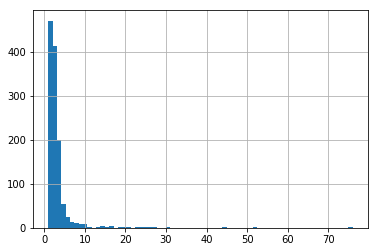

In [53]:
WOS_df['co_author_num'].hist(bins = 70)
plt.show()

### Odd number of the authors (1 = odd-size group)

In [54]:
WOS_df['author_odd_num_dummy'] = np.where(WOS_df['co_author_num']%2 == 0, 0, 1)

In [75]:
WOS_df.groupby('author_odd_num_dummy').mean()['cited_time']

author_odd_num_dummy
0    38.621035
1    40.316879
Name: cited_time, dtype: float64

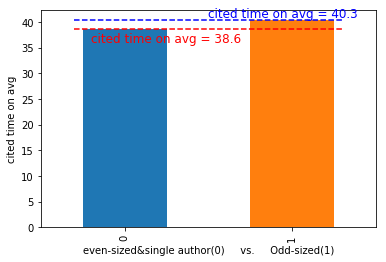

In [88]:
WOS_df.groupby('author_odd_num_dummy').mean()['cited_time'].plot(kind = 'bar')
plt.xlabel('even-sized&single author(0)     vs.     Odd-sized(1)')
plt.ylabel('cited time on avg')
plt.hlines(y = 40.3, xmin = -0.3, xmax = 1.3, linestyles = '--', color = 'blue')
plt.annotate('cited time on avg = 40.3', xy = (0.5, 41), fontsize = 12, color = 'blue')
plt.hlines(y = 38.6, xmin = -0.3, xmax = 1.3, linestyles = '--', color = 'red')
plt.annotate('cited time on avg = 38.6', xy = (-0.2, 36), fontsize = 12, color = 'red')
plt.savefig('./graph/image4', bbox_inches='tight')
plt.show()

### The average h index of the authors

In [89]:
# Author Information
authors_info = pd.read_csv('./data/Author.csv')
authors_info.drop(columns = ['publication_url', 'authors_url'], axis = 1).head(5)

,name,name_id,ttl_publication,h-index,avg_citation_per_item,sum_of_times_cited,without_self_citations,citing_articles,without_self_citations_article
0,"Cosh, A","cosh, a",8,7,42.63,341,339,330,328
1,"Hughes, A","hughes, a",39,17,32.54,1269,1257,1211,1202
2,"Toms, S","toms, s",58,12,7.78,451,380,349,322
3,"Wright, M","wright, m",318,68,49.07,15603,14181,9245,8992
4,"Calzada, Joan","calzada, j",21,8,6.48,136,129,128,122


In [90]:
# By looping a list of the co-authors, calculate a mean of h-index
avg_author_h_index = []
for row, authors in enumerate(list(WOS_df.co_author1)):
    h_index = 0
    count = 0
    for idx in range(len(authors)):
        ind = authors_info[authors_info.name_id == str(authors[idx])].index[0]
        h_index += float(authors_info.loc[ind, ('h-index')])
        count+= 1
    avg_author_h_index.append(float(h_index)/float(count)) # average
WOS_df['avg_authors_h_index'] = avg_author_h_index

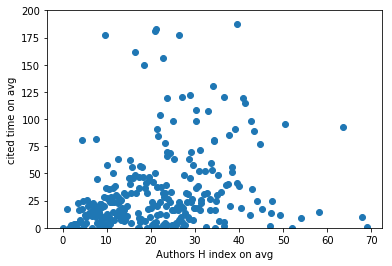

In [96]:
author_sub = WOS_df.groupby('avg_authors_h_index').mean()['cited_time'].reset_index()
plt.scatter(x = list(author_sub.avg_authors_h_index), y = list(author_sub.cited_time))
plt.xlabel('Authors H index on avg')
plt.ylabel('cited time on avg')
plt.ylim(0, 200)
plt.savefig('./graph/image5', bbox_inches='tight')
plt.show()

In [97]:
WOS_df[['Title', 'cited_time', 'avg_authors_h_index', 'co_author_num']].head(5)

,Title,cited_time,avg_authors_h_index,co_author_num
0,Nelson-Plosser revisited: The ACF approach,5,6.333333,3
1,An I(d) model with trend and cycles,5,7.333333,3
2,Two estimators of the long-run variance: Beyon...,9,7.333333,3
3,Testing joint hypotheses when one of the alter...,24,6.000000,2
4,Nonstationarity-extended local Whittle estimation,81,4.333333,3


In [98]:
# By looping a list of the co-authors, calculate a mean of h-index
sum_author_h_index = []
for row, authors in enumerate(list(WOS_df.co_author1)):
    h_index = 0
    count = 0
    for idx in range(len(authors)):
        ind = authors_info[authors_info.name_id == str(authors[idx])].index[0]
        h_index += float(authors_info.loc[ind, ('h-index')])
        count+= 1
    sum_author_h_index.append(float(h_index)) # average
WOS_df['sum_authors_h_index'] = sum_author_h_index

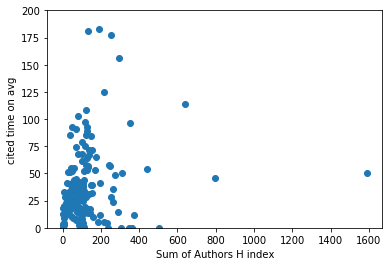

In [99]:
author_sub = WOS_df.groupby('sum_authors_h_index').mean()['cited_time'].reset_index()
plt.scatter(x = list(author_sub.sum_authors_h_index), y = list(author_sub.cited_time))
plt.xlabel('Sum of Authors H index')
plt.ylabel('cited time on avg')
plt.ylim(0, 200)
plt.show()

In [100]:
WOS_df.corr()[['avg_authors_h_index', 'sum_authors_h_index']]

,avg_authors_h_index,sum_authors_h_index
cited_time,0.169086,0.197489
num_of_ref,0.130370,0.166033
yrs_since_published,0.134999,-0.023198
citation_per_yr,0.148329,0.315964
co_author_num,-0.011829,0.855946
author_odd_num_dummy,0.001248,-0.049771
avg_authors_h_index,1.000000,0.406643
sum_authors_h_index,0.406643,1.000000


## 4. Reference

In [101]:
# Reference Information
ref = pd.read_csv('./data/Reference.csv')
ref = ref[ref.ref_year != 'no_reference'] #delete the no reference lines
ref.drop(columns = ['publication_url'], axis =1).head(5)

,citing_title,citing_year,ref_title,ref_year,ref_times_cited
0,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,18-Apr,What is not a real option: Considering boundar...,04-Jan,222
1,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,18-Apr,Match your innovation strategy to your innovat...,06-Apr,247
2,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,18-Apr,NaN,2012,14
3,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,18-Apr,INTRODUCTION: COLLABORATION AND COMPETITION IN...,2013,2
4,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,18-Apr,Innovation ecosystems and the pace of substitu...,16-Apr,26


In [102]:
print('The number of the missing values in the ref_year column:', ref.isnull().sum()['ref_year'])

The number of the missing values in the ref_year column: 371


### Web-scraping the google scholar to fill the na values in the "ref_year" column

In [103]:
# filter the na values in the ref_year column
na_ref_year_df = ref[(ref.ref_year.isnull() == True) & (ref.ref_title.isnull() == False)]
na_ref_year_df[['citing_title', 'ref_title', 'ref_year']].head(5)

,citing_title,ref_title,ref_year
3545,Knowledge Worker Mobility in Context: Pushing ...,"Social ties, prior experience, and venture cre...",NaN
3937,Toward an integrated approach to nutritional q...,Access to adequate food: new indicators to tra...,NaN
3946,Toward an integrated approach to nutritional q...,The Implications of a changing climate on glob...,NaN
5043,Game On? Smoking Cessation Through the Gamific...,Qual Res Psychol Internet,NaN
5327,Equity impacts of price policies to promote he...,Responding to the challenge of resource mobili...,NaN


In [104]:
# Web-scarape the google scholar to parse the year of being pusblished in each referenced ariticles
year_list = []
chrome_options = Options()
chrome_options.add_argument('--lang=en-us')
driver = webdriver.Chrome(chrome_options=chrome_options,executable_path=r"C:/Users/seong/Downloads/chrome/chromedriver")

#Search the titles of the references and parsing the year
for title in list(na_ref_year_df.ref_title):
    driver.get('https://scholar.google.co.uk/schhp?hl=en&as_sdt=0,5')
    driver.implicitly_wait(5)
    driver.find_element_by_xpath('//*[@id="gs_hdr_tsi"]').send_keys(title)
    driver.implicitly_wait(5)
    driver.find_element_by_xpath('//*[@id="gs_hdr_tsb"]/span/span[1]').click()
    driver.implicitly_wait(5)
    web_soup = BeautifulSoup(driver.page_source, "html.parser")
    time.sleep(10)
    try:
        year_parsing = web_soup.select_one('div.gs_a').text
    except:
        continue
    try:
        year = int(re.findall(r'\d+', year_parsing)[0])
    except:
        year = np.nan
    year_list.append(year)
driver.quit()

na_ref_year_df['ref_year'] = year_list

# Manually adding by searching
na_ref_year_df.loc[5043, 'ref_year'] = 2016.0

In [105]:
#Fill the na values in the ref dataframe with the scraped date string
for ind in list(na_ref_year_df.index):
    ref.loc[ind, 'ref_year'] = na_ref_year_df.loc[ind, 'ref_year']

In [106]:
print('The number of the missing values in the ref_year column:', ref.isnull().sum()['ref_year'])

The number of the missing values in the ref_year column: 284


### Preprocessing the date strings to extract the year only

In [107]:
not_null_ref = ref[ref.ref_year.isnull() == False]
not_null_ref.ref_year = not_null_ref.ref_year.astype(str)

number_only = [''.join(re.findall(r'\d+', j)) for j in list(not_null_ref.ref_year)] #extract only decimal
year_only = [i[-2:] for i in number_only] #extract the last two digits
year_list = []
for y in year_only:
    if int(y) > int(str(now.year)[2:4]): # greater than 18
        year_list.append('19' + y)
    else:
        year_list.append('20'+ y)
not_null_ref['ref_year'] = year_list  

for ind in list(not_null_ref.index):
    ref.loc[ind, 'refined_year'] = not_null_ref.loc[ind, 'ref_year']

### Fill the na values in the ref_year column with the references' year on average in each publication

In [108]:
for url in list(ref.publication_url.unique()): # url is a primary key to find a dataline in the base data
    url_group_year = ref[ref.publication_url == url] # filter one journal
    try:
        na_list_index = url_group_year[url_group_year.refined_year.isnull()].index #extract the index of having na on year of publishment
        mean_year_of_group = url_group_year[url_group_year.refined_year.isnull() == False]['refined_year'].values.astype(int).mean().astype(int)
        ref.loc[list(na_list_index), 'refined_year'] = mean_year_of_group #fill na with the average year in the reference group
    except:
        continue # No na values, then continue the loop
               
ref.refined_year = ref.refined_year.astype(int)
ref.reset_index(inplace= True)

In [109]:
print('The number of the missing values in the ref_year column:', ref.isnull().sum()['refined_year'])

The number of the missing values in the ref_year column: 0


### Yearly Citation Number

In [110]:
# yearly_citation_num 
ref['yearly_citation_num'] = [int(ref.loc[i,'ref_times_cited'])/(now.year + 1 - ref.loc[i, 'refined_year']) for i in range(len(ref))]

In [111]:
ref[['citing_title', 'ref_title', 'ref_year', 'ref_times_cited', 'refined_year', 'yearly_citation_num']].head(5)

,citing_title,ref_title,ref_year,ref_times_cited,refined_year,yearly_citation_num
0,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,What is not a real option: Considering boundar...,04-Jan,222,2004,14.800000
1,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,Match your innovation strategy to your innovat...,06-Apr,247,2006,19.000000
2,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,NaN,2012,14,2012,2.000000
3,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,INTRODUCTION: COLLABORATION AND COMPETITION IN...,2013,2,2013,0.333333
4,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,Innovation ecosystems and the pace of substitu...,16-Apr,26,2016,8.666667


### Group by each publication, and summate the yearly citation number with the relevant references

In [112]:
ref_url_groupby = ref.groupby('publication_url').mean()['yearly_citation_num'].reset_index()
ref_url_groupby.rename(columns={'yearly_citation_num':'ref_yearly_cited_avg'}, inplace= True)

### Merge the ref dataframe with the WOS_df dataframe

In [113]:
# Merge key = publication URL on the Web of Science
merged_WOS_df = WOS_df.merge(right = ref_url_groupby, how = 'left', left_on = ['WOS_URL'], right_on = ['publication_url'])
merged_WOS_df['ref_yearly_cited_avg'] = merged_WOS_df['ref_yearly_cited_avg'].fillna(value=0)
merged_WOS_df.drop(columns=['publication_url'], axis=1, inplace=True)

In [114]:
merged_WOS_df[['Title', 'ref_yearly_cited_avg', 'num_of_ref', 'cited_time']].head(5)

,Title,ref_yearly_cited_avg,num_of_ref,cited_time
0,Nelson-Plosser revisited: The ACF approach,18.801852,42,5
1,An I(d) model with trend and cycles,3.940034,22,5
2,Two estimators of the long-run variance: Beyon...,26.560935,21,9
3,Testing joint hypotheses when one of the alter...,10.841103,58,24
4,Nonstationarity-extended local Whittle estimation,6.388188,21,81


In [137]:
np.corrcoef(list(ref_sub.num_of_ref), list(ref_sub.cited_time))

array([[1.        , 0.31498311],
       [0.31498311, 1.        ]])

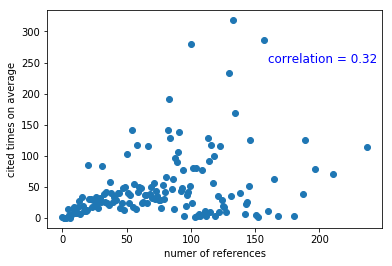

In [198]:
ref_sub = merged_WOS_df.groupby('num_of_ref').mean()['cited_time'].reset_index()
plt.scatter(x = list(ref_sub.num_of_ref), y = list(ref_sub.cited_time))
plt.xlabel('numer of references')
plt.ylabel('cited times on average')
plt.annotate('correlation = 0.32', xy = (160, 250), fontsize = 12, color = 'blue')
plt.savefig('./graph/image6', bbox_inches='tight')
plt.show()

In [138]:
np.corrcoef(list(ref_sub2.ref_yearly_cited_avg), list(ref_sub2.cited_time))

array([[1.        , 0.15566191],
       [0.15566191, 1.        ]])

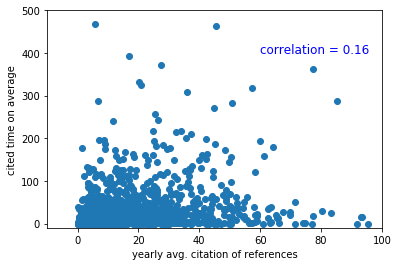

In [199]:
ref_sub2 = merged_WOS_df.groupby('ref_yearly_cited_avg').mean()['cited_time'].reset_index()
plt.scatter(x = list(ref_sub2.ref_yearly_cited_avg), y = list(ref_sub2.cited_time))
plt.xlabel('yearly avg. citation of references')
plt.ylabel('cited time on average')
plt.ylim(-10, 500)
plt.xlim(-10, 100)
plt.annotate('correlation = 0.16', xy = (60,400), fontsize = 12, color = 'blue')
plt.savefig('./graph/image7', bbox_inches='tight')
plt.show()

## 5. Organization

In [127]:
print("=== Research Field: Anesthesiology ===")
pd.read_csv('./data/organizationbyResearchArea/Anesthesiology.csv').head(5)

=== Research Field: Anesthesiology ===


,Name,Rank,Web of Science Documents,Category Normalized Citation Impact,Times Cited,% Docs Cited
0,University of California System,1.0,6276.0,1.45,136231.0,72.34
1,Harvard University,2.0,5845.0,1.33,105297.0,70.88
2,University of California San Francisco,3.0,2814.0,1.62,74494.0,74.88
3,University of Toronto,4.0,3839.0,1.43,72983.0,74.58
4,University of London,5.0,3787.0,1.49,67801.0,69.26


In [128]:
#research field filter
re_area = []
for r_list in merged_WOS_df.WOS_cate:
    for r_ele in r_list:
        if not r_ele.strip() in re_area:
            re_area.append(r_ele.strip())
print("The number of the target research categories:", len(re_area))

The number of the target research categories: 90


### Category impact factor and  Ranking on average by a group of the institution in each publication

In [129]:
for idx, r_list in enumerate(list(merged_WOS_df.WOS_cate)): # list research fields
    ranking_avg = [] # initialize
    cate_impact_factor = [] # initialize
    for r_ele in r_list:  # loop each element of the research fields
        area_df = pd.read_csv('./data/organizationbyResearchArea/'+str(r_ele.strip())+'.csv') # access the indicators dataset in each field
        ranking = 0
        cate_i_f = 0
        count = 0
        for uni in list(merged_WOS_df.loc[idx, 'organization']): # loop the university list
            try:
                index_loc = area_df.Name[area_df.Name == uni].index[0] # find university name index
                ranking += area_df.loc[index_loc, 'Rank'] # Sum of Ranking
                cate_i_f += area_df.loc[index_loc, 'Category Normalized Citation Impact'] #Sum of CNCI
                count+=1
            except:
                pass
        ranking_avg.append(ranking / float(count)) # average ranking in the single research field
        cate_impact_factor.append(cate_i_f / float(count)) # average CNCI in the single research field
    merged_WOS_df.loc[idx, 'avg_organ_ranking'] = sum(ranking_avg) / float(len(ranking_avg)) # average ranking with all the research fields
    merged_WOS_df.loc[idx, 'avg_organ_cate_impact_factor'] = sum(cate_impact_factor) / float(len(ranking_avg)) # average CNCI with all the research fields

In [130]:
merged_WOS_df[['Title', 'WOS_cate', 'organization', 'avg_organ_ranking', 'avg_organ_cate_impact_factor', 'cited_time']].head(5)

,Title,WOS_cate,organization,avg_organ_ranking,avg_organ_cate_impact_factor,cited_time
0,Nelson-Plosser revisited: The ACF approach,"[Economics, Mathematics, Interdisciplinary Ap...","[Imperial College London, University of Glasgo...",224.888889,1.106667,5
1,An I(d) model with trend and cycles,"[Economics, Mathematics, Interdisciplinary Ap...","[Imperial College London, University of London]",55.000000,1.478333,5
2,Two estimators of the long-run variance: Beyon...,"[Economics, Mathematics, Interdisciplinary Ap...","[Imperial College London, University of London]",55.000000,1.478333,9
3,Testing joint hypotheses when one of the alter...,"[Economics, Mathematics, Interdisciplinary Ap...",[Imperial College London],103.333333,1.310000,24
4,Nonstationarity-extended local Whittle estimation,"[Economics, Mathematics, Interdisciplinary Ap...","[Imperial College London, University of London]",55.000000,1.478333,81


In [135]:
np.corrcoef(list(ranking_sub.avg_organ_ranking), list(ranking_sub.cited_time))

array([[ 1.        , -0.10677888],
       [-0.10677888,  1.        ]])

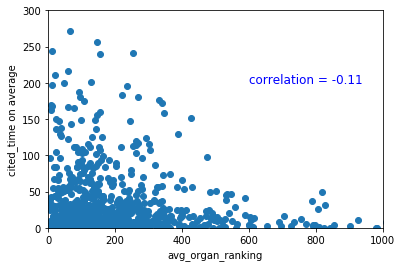

In [200]:
ranking_sub = merged_WOS_df.groupby('avg_organ_ranking').mean()['cited_time'].reset_index()
plt.scatter(x = list(ranking_sub.avg_organ_ranking), y = list(ranking_sub.cited_time))
plt.xlabel('avg_organ_ranking')
plt.ylabel('cited_time on average')
plt.ylim(0, 300)
plt.xlim(0, 1000)
plt.annotate('correlation = -0.11', xy = (600,200), fontsize = 12, color = 'blue')
plt.savefig('./graph/image9', bbox_inches='tight')
plt.show()

In [136]:
np.corrcoef(list(organization_sub['avg_organ_cate_impact_factor']), list(organization_sub['cited_time']))

array([[1.        , 0.18660725],
       [0.18660725, 1.        ]])

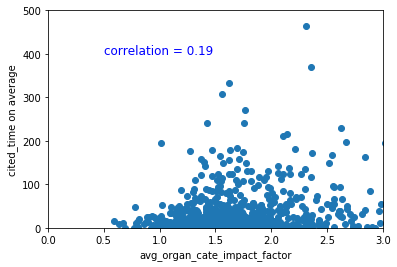

In [201]:
organization_sub = merged_WOS_df.groupby('avg_organ_cate_impact_factor').mean()['cited_time'].reset_index()
plt.scatter(x = list(organization_sub['avg_organ_cate_impact_factor']), y = list(organization_sub['cited_time']))
plt.xlabel('avg_organ_cate_impact_factor')
plt.ylabel('cited_time on average')
plt.ylim(0, 500)
plt.xlim(0, 3)
plt.annotate('correlation = 0.19', xy = (0.5,400), fontsize = 12, color = 'blue')
plt.savefig('./graph/image10', bbox_inches='tight')
plt.show()

## 6. Research Field

In [154]:
cate_df = pd.read_csv('./data/Category.csv')
cate_df = cate_df.replace('Not Available', np.nan)
cate_df = cate_df.dropna(how='any', axis=0)
cate_df.drop(columns = ['page_url' ,'category2', 'edition'], axis = 1).head(5)

,category1,year,journal_num,articles,total_cites,median_impact_factor,aggregate_impact_factor,aggregate_immediacy_index,aggregate_cited_half_life,aggregate_citing_half_life
0,ACOUSTICS,2016.0,31.0,"5,088","160,629",1.547,2.102,0.528,>10.0,9.6
1,ACOUSTICS,2015.0,32.0,"4,916","138,295",1.103,1.853,0.446,9.6,9.6
2,ACOUSTICS,2014.0,31.0,"4,273","125,484",0.912,1.741,0.400,9.6,9.7
3,ACOUSTICS,2013.0,30.0,"4,355","117,073",1.107,1.840,0.357,9.2,9.5
4,ACOUSTICS,2012.0,31.0,"4,139","111,560",1.097,1.710,0.332,9.1,9.5


In [155]:
def list_avg(list_array):
    j = 0.0
    count = 0.0
    for i in list_array:
        j += i
        count += 1
    return j/count

In [156]:
row_line = 0
for cate, yrs in zip(list(merged_WOS_df.WOS_cate), list(merged_WOS_df.published_yrs)):
    sum_avg_cate_impact_factor = 0
    for c in cate:
        try:
            filtered_df = cate_df[cate_df.category1 == c.strip().upper()]
            start = filtered_df.index[0]
            end = filtered_df[filtered_df.year == float(yrs)].index[0]
            aggregate_impact_factor = [float(i) for i in list(filtered_df.loc[start:end,'aggregate_impact_factor'])]
            sum_avg_cate_impact_factor += list_avg(aggregate_impact_factor)
        except:
            filtered_df = cate_df[cate_df.category1 == c.strip().upper()]
            if filtered_df.shape[0] == 0:
                continue
            else:
                start = filtered_df.index[0]
                end = start + filtered_df.shape[0] - 1
                aggregate_impact_factor = [float(i) for i in list(filtered_df.loc[start:end,'aggregate_impact_factor'])]
                sum_avg_cate_impact_factor += list_avg(aggregate_impact_factor)
    merged_WOS_df.loc[row_line, 'avg_research_field_impact_factor'] = sum_avg_cate_impact_factor/len(cate)
    row_line += 1

In [157]:
merged_WOS_df[['Title', 'WOS_cate', 'published_yrs', 'avg_research_field_impact_factor', 'cited_time']].head(5)

,Title,WOS_cate,published_yrs,avg_research_field_impact_factor,cited_time
0,Nelson-Plosser revisited: The ACF approach,"[Economics, Mathematics, Interdisciplinary Ap...",2013,1.401417,5
1,An I(d) model with trend and cycles,"[Economics, Mathematics, Interdisciplinary Ap...",2011,1.362444,5
2,Two estimators of the long-run variance: Beyon...,"[Economics, Mathematics, Interdisciplinary Ap...",2009,1.346792,9
3,Testing joint hypotheses when one of the alter...,"[Economics, Mathematics, Interdisciplinary Ap...",2007,1.318733,24
4,Nonstationarity-extended local Whittle estimation,"[Economics, Mathematics, Interdisciplinary Ap...",2007,1.318733,81


In [159]:
np.corrcoef(list(research_sub['avg_research_field_impact_factor']), list(research_sub['cited_time']))

array([[ 1.        , -0.01184462],
       [-0.01184462,  1.        ]])

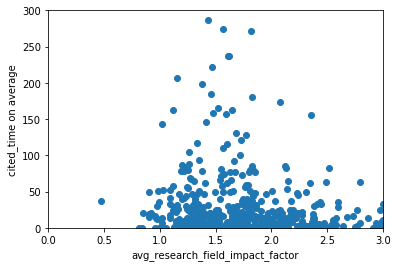

In [158]:
research_sub = merged_WOS_df.groupby('avg_research_field_impact_factor').mean()['cited_time'].reset_index()
plt.scatter(x = list(research_sub['avg_research_field_impact_factor']), y = list(research_sub['cited_time']))
plt.xlabel('avg_research_field_impact_factor')
plt.ylabel('cited_time on average')
plt.xlim(0, 3)
plt.ylim(0, 300)
plt.show()

## 7. Journal

In [161]:
journal_type = pd.read_csv('./data/Journal Type.csv')
refined_journal_df = journal_type[['journal_type_main_page', 'year', 'journal_impact_factor']]
refined_journal_df = refined_journal_df[refined_journal_df.journal_impact_factor.isnull() == False]
refined_journal_df.head(5)

,journal_type_main_page,year,journal_impact_factor
0,JOURNAL OF ECONOMETRICS,2016,1.633
1,JOURNAL OF ECONOMETRICS,2015,1.611
2,JOURNAL OF ECONOMETRICS,2014,1.600
3,JOURNAL OF ECONOMETRICS,2013,1.533
4,JOURNAL OF ECONOMETRICS,2012,1.710


In [162]:
row_line = 0
for t, yrs in zip(list(merged_WOS_df.journal_type), list(merged_WOS_df.published_yrs)):
    avg_impact_factor = 0
    try:
        filtered_df = refined_journal_df[refined_journal_df.journal_type_main_page == t.split(',')[0].strip().upper()]
        start = filtered_df.index[0] # latest yrs index
        end = filtered_df[filtered_df.year == float(yrs.strip())].index[0]
        journal_impact_factors = [float(i) for i in list(filtered_df.loc[start:end,'journal_impact_factor'])]
        avg_impact_factor += list_avg(journal_impact_factors)
    except:
        filtered_df = refined_journal_df[refined_journal_df.journal_type_main_page ==  t.split(',')[0].strip().upper()]
        if filtered_df.shape[0] == 0:
            merged_WOS_df.loc[row_line, 'avg_journal_impact_factor'] = 0
            row_line += 1
            continue
        else:
            start = filtered_df.index[0]
            end = start + filtered_df.shape[0] - 1
            journal_impact_factors = [float(i) for i in list(filtered_df.loc[start:end,'journal_impact_factor'])]
            avg_impact_factor += list_avg(journal_impact_factors)
    merged_WOS_df.loc[row_line, 'avg_journal_impact_factor'] = avg_impact_factor
    row_line += 1

In [163]:
merged_WOS_df[['Title', 'journal_type', 'published_yrs', 'avg_journal_impact_factor', 'cited_time']].head(5)

,Title,journal_type,published_yrs,avg_journal_impact_factor,cited_time
0,Nelson-Plosser revisited: The ACF approach,JOURNAL OF ECONOMETRICS,2013,1.594250,5
1,An I(d) model with trend and cycles,JOURNAL OF ECONOMETRICS,2011,1.572667,5
2,Two estimators of the long-run variance: Beyon...,JOURNAL OF ECONOMETRICS,2009,1.644125,9
3,Testing joint hypotheses when one of the alter...,JOURNAL OF ECONOMETRICS,2007,1.693300,24
4,Nonstationarity-extended local Whittle estimation,JOURNAL OF ECONOMETRICS,2007,1.693300,81


In [165]:
np.corrcoef(list(journal_sub.avg_journal_impact_factor), list(journal_sub.cited_time))

array([[1.        , 0.17968447],
       [0.17968447, 1.        ]])

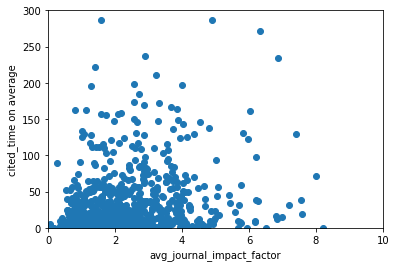

In [164]:
journal_sub = merged_WOS_df.groupby('avg_journal_impact_factor').mean()['cited_time'].reset_index()
plt.scatter(x = list(journal_sub.avg_journal_impact_factor), y = list(journal_sub.cited_time))
plt.xlabel('avg_journal_impact_factor')
plt.ylabel('cited_time on average')
plt.xlim(0, 10)
plt.ylim(0, 300)
plt.show()

## 8. Diversity

### Ethnicity (diversity)

In [84]:
from ethnicolr import pred_wiki_ln
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

def df_make(w):
    df = pd.DataFrame()
    df['last_name'] = w
    return df

def list_nested(l):
    k = df_make(l)
    pred_wiki_ln(k, 'last_name')
    return [each.split(',')[0] for each in k.race]

Using TensorFlow backend.


In [ ]:
WOS_df = pd.read_pickle('C:/Users/seong/Documents/00. Summer/1. Workforce/Individual HW/01. Crawling(WebOfScience)/data/final.pkl')
for i in list(np.arange(0, 1495, 16)):
    try:
        df_eth = pd.read_pickle('./data/ethnictity_df.pkl')
    except:
        df_eth = pd.DataFrame(columns = ['names', 'ethnicity'])
    if df_eth.shape[0] > i:            #df = 235 > i=250
        print("DONE", df_eth.shape[0])
        continue
    else:
        start = df_eth.shape[0]
        end = i
        for j in WOS_df.co_author1[start:end]:
            row_sc = df_eth.shape[0]
            df_eth.loc[row_sc, 'names'] = j
            df_eth.loc[row_sc, 'ethnicity'] = list_nested(j)
            print("%dth. %s, %s" %(row_sc+1, df_eth.loc[row_sc, 'names'], df_eth.loc[row_sc, 'ethnicity']))
            df_eth.to_pickle('./data/ethnictity_df.pkl')

In [166]:
ethnicity = pd.read_pickle('./data/ethnictity_df.pkl')
merged_WOS_df['ethnicity'] = ethnicity['ethnicity']

In [167]:
merged_WOS_df['multi_eth_dummy'] = merged_WOS_df['ethnicity'].apply(lambda x: 0 if len(list(set(x))) == 1 else 1)

In [168]:
merged_WOS_df.multi_eth_dummy.value_counts()

0    1007
1     220
Name: multi_eth_dummy, dtype: int64

In [169]:
eth_sub = merged_WOS_df.groupby('multi_eth_dummy').mean()['cited_time'].reset_index()
eth_sub.eth_diversity = eth_sub.multi_eth_dummy.round(2)
eth_sub.cited_time = eth_sub.cited_time.round(2)
eth_sub.index = eth_sub.eth_diversity
eth_sub = eth_sub['cited_time']
eth_sub.head

<bound method NDFrame.head of multi_eth_dummy
0    39.30
1    40.37
Name: cited_time, dtype: float64>

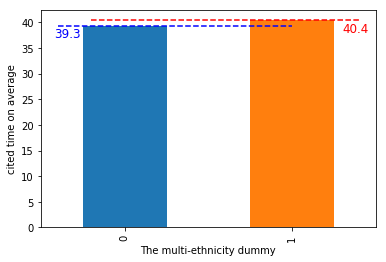

In [205]:
eth_sub.plot(kind = 'bar')
plt.xlabel('The multi-ethnicity dummy')
plt.ylabel('cited time on average')
plt.hlines(y = 39.3, xmin = -0.4, xmax = 1, linestyles = '--', color = 'blue')
plt.annotate('39.3', xy = (-0.42, 37), fontsize = 12, color = 'blue')
plt.hlines(y = 40.4, xmin = -0.2, xmax = 1.4, linestyles = '--', color = 'red')
plt.annotate('40.4', xy = (1.3, 38), fontsize = 12, color = 'red')
plt.savefig('./graph/image11', bbox_inches='tight')
plt.show()

### Organization Country (diversity)

In [171]:
merged_WOS_df['num_country_set'] = merged_WOS_df['organ_country'].apply(lambda x: len(list(set(x)))) 

In [172]:
print("number of Country in set on count")
merged_WOS_df.num_country_set.value_counts()

number of Country in set on count


1     548
2     422
3     163
4      61
5      15
7       4
6       4
12      3
11      3
10      2
15      1
13      1
Name: num_country_set, dtype: int64

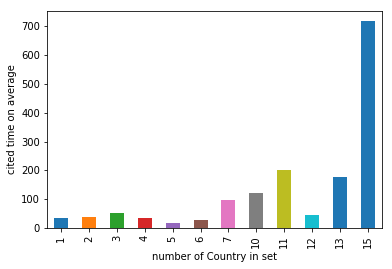

In [173]:
merged_WOS_df.groupby('num_country_set').mean()['cited_time'].plot(kind = 'bar')
plt.xlabel('number of Country in set')
plt.ylabel('cited time on average')
plt.show()

In [174]:
for i, num in enumerate(list(merged_WOS_df['num_country_set'])):
    if num == 1:
        merged_WOS_df.loc[i, 'organ_multi_country_dummy'] = 0
    else:
        merged_WOS_df.loc[i, 'organ_multi_country_dummy'] = 1

In [202]:
merged_WOS_df.groupby('organ_multi_country_dummy').mean()['cited_time']

organ_multi_country_dummy
0.0    35.782847
1.0    42.480118
Name: cited_time, dtype: float64

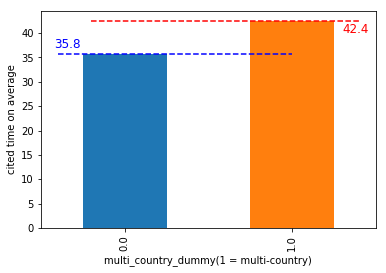

In [206]:
merged_WOS_df.groupby('organ_multi_country_dummy').mean()['cited_time'].plot(kind = 'bar')
plt.xlabel('multi_country_dummy(1 = multi-country)')
plt.ylabel('cited time on average')
plt.hlines(y = 35.78, xmin = -0.4, xmax = 1, linestyles = '--', color = 'blue')
plt.annotate('35.8', xy = (-0.42, 37), fontsize = 12, color = 'blue')
plt.hlines(y =42.4, xmin = -0.2, xmax = 1.4, linestyles = '--', color = 'red')
plt.annotate('42.4', xy = (1.3, 40), fontsize = 12, color = 'red')
plt.savefig('./graph/image12', bbox_inches='tight')
plt.show()

In [176]:
merged_WOS_df[['Title', 'ethnicity', 'multi_eth_dummy', 'organ_country', 'num_country_set', 'organ_multi_country_dummy']].head(5)

,Title,ethnicity,multi_eth_dummy,organ_country,num_country_set,organ_multi_country_dummy
0,Nelson-Plosser revisited: The ACF approach,"[GreaterAfrican, GreaterEuropean, GreaterEurop...",1,"[SCOTLAND, ENGLAND, ENGLAND, ITALY]",3,1.0
1,An I(d) model with trend and cycles,"[GreaterAfrican, GreaterEuropean, GreaterEurop...",1,"[ENGLAND, ENGLAND]",1,0.0
2,Two estimators of the long-run variance: Beyon...,"[GreaterAfrican, GreaterEuropean, GreaterEurop...",1,"[ENGLAND, ENGLAND]",1,0.0
3,Testing joint hypotheses when one of the alter...,"[GreaterAfrican, GreaterEuropean]",1,[ENGLAND],1,0.0
4,Nonstationarity-extended local Whittle estimation,"[GreaterAfrican, GreaterEuropean, GreaterEurop...",1,"[ENGLAND, ENGLAND]",1,0.0


### Institution (diversity)

In [177]:
merged_WOS_df['num_uni_set'] = merged_WOS_df['organization'].apply(lambda x: len(list(set(x)))) 

In [178]:
print("number of Country in set by count")
merged_WOS_df.num_uni_set.value_counts()

number of Country in set by count


1     336
2     336
3     252
4     144
5      71
6      42
7      17
8       9
9       5
12      3
16      2
50      1
10      1
30      1
15      1
19      1
21      1
22      1
23      1
25      1
11      1
Name: num_uni_set, dtype: int64

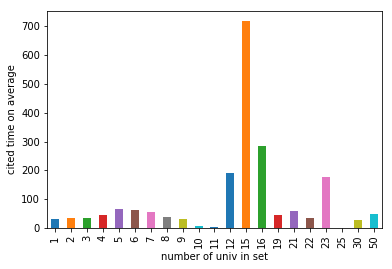

In [179]:
merged_WOS_df.groupby('num_uni_set').mean()['cited_time'].plot(kind = 'bar')
plt.xlabel('number of univ in set')
plt.ylabel('cited time on average')
plt.show()

In [180]:
for i, num in enumerate(list(merged_WOS_df['num_uni_set'])):
    if num == 1:
        merged_WOS_df.loc[i, 'multi_univ_dummy'] = 0
    else:
        merged_WOS_df.loc[i, 'multi_univ_dummy'] = 1

In [207]:
merged_WOS_df.groupby('multi_univ_dummy').mean()['cited_time']

multi_univ_dummy
0.0    31.886905
1.0    42.355780
Name: cited_time, dtype: float64

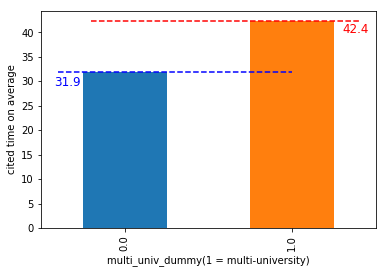

In [223]:
merged_WOS_df.groupby('multi_univ_dummy').mean()['cited_time'].plot(kind = 'bar')
plt.xlabel('multi_univ_dummy(1 = multi-university)')
plt.ylabel('cited time on average')
plt.hlines(y = 31.88, xmin = -0.4, xmax = 1, linestyles = '--', color = 'blue')
plt.annotate('31.9', xy = (-0.42, 29), fontsize = 12, color = 'blue')
plt.hlines(y =42.35, xmin = -0.2, xmax = 1.4, linestyles = '--', color = 'red')
plt.annotate('42.4', xy = (1.3, 40), fontsize = 12, color = 'red')
plt.savefig('./graph/image13', bbox_inches='tight')
plt.show()

## 9. Take the log to the cited time

In [112]:
merged_WOS_df['log_cited_time'] = merged_WOS_df['cited_time'].apply(lambda x: math.log(x+1))
merged_WOS_df['log_cited_time_per_yr'] = merged_WOS_df['citation_per_yr'].apply(lambda x: math.log(x+1))

## 10. Title+Keywords similar to Abstract

In [211]:
import nltk

def extract_nouns(text):
    # use tokenizer to split text into individual words
    words = nltk.word_tokenize(text)    
    # use tagger to categorize all words
    tags = nltk.pos_tag(words)
    # keep nouns only (nn, nns, nnp, nnps)
    only_nouns = []
    for word, pos in tags: 
        if (pos == 'NN' or pos == 'NNS' or pos == 'NNP' or pos == 'NNPS'):
            only_nouns.append(word.lower())
    return only_nouns  

def intersect(a, b):
    return list(set(a) & set(b))
def union (a,b):
    return  list(set(a).union(b))
       
def similarity(lst1, lst2):
    numerator =  len(intersect(lst1,lst2))
    denom = len(union(lst1,lst2))
    if not denom:
        sim = 0
    else:
        sim = round(float(numerator)/denom,3)
    return sim   

In [212]:
df = merged_WOS_df.copy()
df.dropna(axis=0, how='any', inplace=True)

In [213]:
sim_list = []
for idx in range(len(df)):
    title_keyword = extract_nouns(list(df.Title)[idx])+[i.lower() for i in list(df.keywords)[idx]]
    abstract_nouns = extract_nouns(list(df.abstract)[idx])
    sim_list.append(similarity(title_keyword, abstract_nouns))
df['sim'] = sim_list

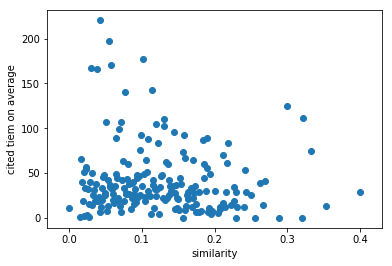

In [214]:
sim_sub = df.groupby('sim').mean()['cited_time'].reset_index()
plt.scatter(x = list(sim_sub.sim), y = list(sim_sub.cited_time))
plt.ylabel('cited tiem on average')
plt.xlabel('similarity')
plt.show()

In [215]:
keyword_dummy = []
for i, j in enumerate(list(df.keywords)):
    if len(j) > 0:
        keyword_dummy.append(int(1))
    else:
        keyword_dummy.append(int(0))
df['keyword_provided_dummy'] = keyword_dummy

In [217]:
df.groupby('keyword_provided_dummy').mean()['cited_time']

keyword_provided_dummy
0    20.112676
1    45.834166
Name: cited_time, dtype: float64

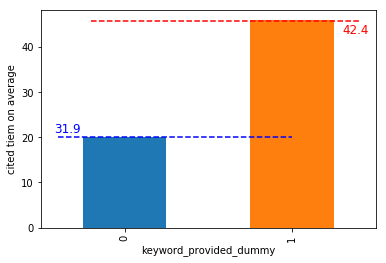

In [224]:
df.groupby('keyword_provided_dummy').mean()['cited_time'].plot(kind = 'bar')
plt.ylabel('cited tiem on average')
plt.hlines(y = 20.1, xmin = -0.4, xmax = 1, linestyles = '--', color = 'blue')
plt.annotate('31.9', xy = (-0.42, 21), fontsize = 12, color = 'blue')
plt.hlines(y =45.8, xmin = -0.2, xmax = 1.4, linestyles = '--', color = 'red')
plt.annotate('42.4', xy = (1.3, 43), fontsize = 12, color = 'red')
plt.savefig('./graph/image14', bbox_inches='tight')
plt.show()

## 11. Preprocessing and Feature Engineering Result

1. **yrs_since_published**: year pass since published. ex) published year: 2018 -> yrs_since_published: 1
2. **co_author_num**: the number of the co-authors
3. **avg_authors_h_index**: authors' h-index on average
4. **sim**: similarity between title+keywords and abstract
5. **num_of_ref**: the number of the references for a target publication
6. **ref_yearly_cited_avg**: the cited time of the references on average for a target publication
7. **avg_organ_ranking**: a mean of the ranking of the organisations in the relevant research categories
8. **avg_organ_cate_impact_factor**: a mean of the category impact factor in the relevant research categories
9. **avg_research_field_impact_factor**: a mean of impact factor in the relevant research categories
10. **avg_journal_impact_factor**: a mean of impact factor in the relevant journal
11. **multi_eth_dummy**: 1 if the number of authors' ethnicities is above 1. Otherwise, 0.
12. **organ_multi_country_dummy**: 1 if the number of organisations' countries is above 1. Otherwise, 0.
13. **multi_univ_dummy**: 1 if the number of organisations is over 1. Otherwise, 0.
14. **author_odd_num_dummy**: 1 if the number of co-authors is odd and greater than 1. Otherwise, 0.
15. **keyword_provided_dummy**: 1 if keywords are provided. Otherwise, 0.

In [119]:
df.to_pickle('./data/preprocessed_df.pkl')

In [120]:
df.columns

Index(['WOS_URL', 'Title', 'co_author1', 'co_author2', 'journal_type',
       'research_areas', 'WOS_cate', 'address', 'organization', 'date',
       'cited_time', 'num_of_ref', 'abstract', 'keywords', 'publisher',
       'published_yrs', 'yrs_since_published', 'citation_per_yr',
       'organ_country', 'co_author_num', 'author_odd_num_dummy',
       'avg_authors_h_index', 'sum_authors_h_index', 'ref_yearly_cited_avg',
       'avg_organ_ranking', 'avg_organ_cate_impact_factor',
       'avg_research_field_impact_factor', 'avg_journal_impact_factor',
       'ethnicity', 'multi_eth_dummy', 'num_country_set',
       'organ_multi_country_dummy', 'num_uni_set', 'multi_univ_dummy',
       'log_total_cited_time', 'log_cited_time_per_yr', 'log_cited_time',
       'sim', 'keyword_provided_dummy'],
      dtype='object')

In [226]:
preprocessed_df = pd.read_pickle('./data/preprocessed_df.pkl')
final_df = preprocessed_df[['log_cited_time_per_yr','citation_per_yr', 'log_cited_time', 'cited_time', 'yrs_since_published',\
               'co_author_num','avg_authors_h_index', 'author_odd_num_dummy',\
               'num_of_ref', 'ref_yearly_cited_avg', \
               'avg_organ_ranking', 'avg_organ_cate_impact_factor',\
               'avg_research_field_impact_factor', 'avg_journal_impact_factor',\
               'multi_eth_dummy', 'organ_multi_country_dummy','multi_univ_dummy', 'sim', 'keyword_provided_dummy']]
final_df.head(5)

,log_cited_time_per_yr,citation_per_yr,log_cited_time,cited_time,yrs_since_published,co_author_num,avg_authors_h_index,author_odd_num_dummy,num_of_ref,ref_yearly_cited_avg,avg_organ_ranking,avg_organ_cate_impact_factor,avg_research_field_impact_factor,avg_journal_impact_factor,multi_eth_dummy,organ_multi_country_dummy,multi_univ_dummy,sim,keyword_provided_dummy
0,0.606136,0.833333,1.791759,5,6,3,6.333333,1,42,18.801852,224.888889,1.106667,1.401417,1.594250,1,1.0,1.0,0.021,1
1,0.485508,0.625000,1.791759,5,8,3,7.333333,1,22,3.940034,55.000000,1.478333,1.362444,1.572667,1,0.0,1.0,0.036,1
2,0.641854,0.900000,2.302585,9,10,3,7.333333,1,21,26.560935,55.000000,1.478333,1.346792,1.644125,1,0.0,1.0,0.093,1
3,1.098612,2.000000,3.218876,24,12,2,6.000000,0,58,10.841103,103.333333,1.310000,1.318733,1.693300,1,0.0,0.0,0.042,1
4,2.047693,6.750000,4.406719,81,12,3,4.333333,1,21,6.388188,55.000000,1.478333,1.318733,1.693300,1,0.0,1.0,0.051,1


In [227]:
final_df.to_csv('./data/final_df.csv', index = False)

# Model Building

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.compat import lzip
from statsmodels.graphics.gofplots import ProbPlot

%matplotlib inline

final_df = pd.read_csv('./data/final_df.csv')

In [4]:
final_df.shape

(1072, 19)

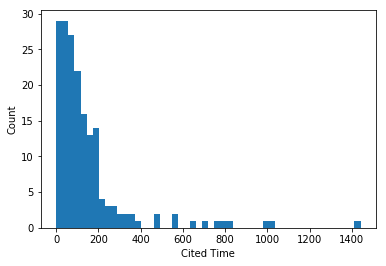

In [237]:
plt.hist(list(df_sub['cited_time']), bins = 50)
plt.xlabel('Cited Time')
plt.ylabel('Count')
plt.savefig('./graph/image15', bbox_inches='tight')
plt.show()

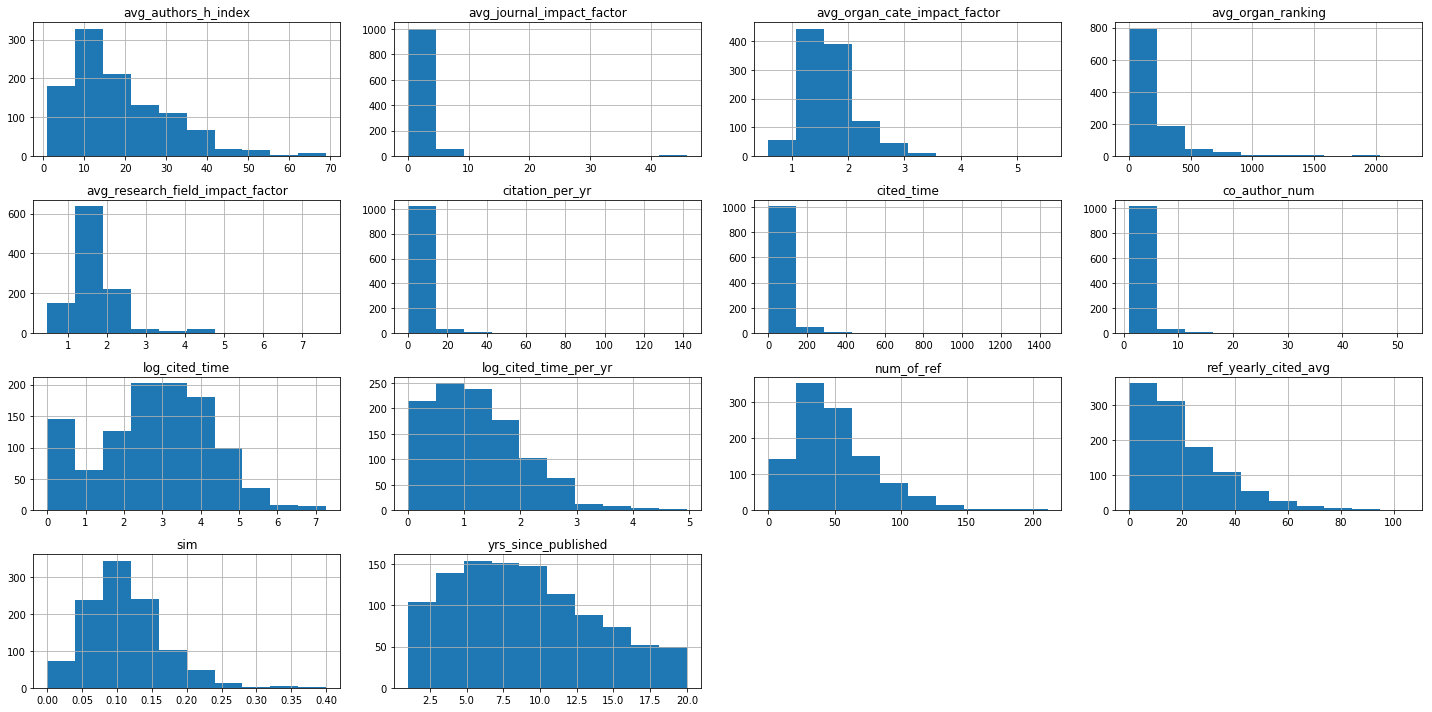

In [241]:
final_df.hist(column=['log_cited_time_per_yr', 'citation_per_yr', 'log_cited_time',\
       'cited_time', 'yrs_since_published', 'co_author_num',\
       'avg_authors_h_index','num_of_ref',\
       'ref_yearly_cited_avg', 'avg_organ_ranking',\
       'avg_organ_cate_impact_factor', 'avg_research_field_impact_factor',\
       'avg_journal_impact_factor', 'sim'])
plt.rcParams['figure.figsize'] =  (20.0, 10.0)
plt.tight_layout()
plt.show()

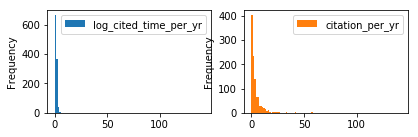

In [128]:
final_df[['log_cited_time_per_yr', 'citation_per_yr']].plot(kind = 'hist', subplots=True, layout=(9, 3), figsize=(10, 20), bins = 100)
plt.rcParams['figure.figsize'] =  (20.0, 10.0)
plt.show()

## 1. Multicollinearity

In [244]:
final_df.head()

,log_cited_time_per_yr,citation_per_yr,log_cited_time,cited_time,yrs_since_published,co_author_num,avg_authors_h_index,author_odd_num_dummy,num_of_ref,ref_yearly_cited_avg,avg_organ_ranking,avg_organ_cate_impact_factor,avg_research_field_impact_factor,avg_journal_impact_factor,multi_eth_dummy,organ_multi_country_dummy,multi_univ_dummy,sim,keyword_provided_dummy
0,0.606136,0.833333,1.791759,5,6,3,6.333333,1,42,18.801852,224.888889,1.106667,1.401417,1.594250,1,1.0,1.0,0.021,1
1,0.485508,0.625000,1.791759,5,8,3,7.333333,1,22,3.940034,55.000000,1.478333,1.362444,1.572667,1,0.0,1.0,0.036,1
2,0.641854,0.900000,2.302585,9,10,3,7.333333,1,21,26.560935,55.000000,1.478333,1.346792,1.644125,1,0.0,1.0,0.093,1
3,1.098612,2.000000,3.218876,24,12,2,6.000000,0,58,10.841103,103.333333,1.310000,1.318733,1.693300,1,0.0,0.0,0.042,1
4,2.047693,6.750000,4.406719,81,12,3,4.333333,1,21,6.388188,55.000000,1.478333,1.318733,1.693300,1,0.0,1.0,0.051,1


In [245]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [246]:
X = final_df.drop(columns = ['log_cited_time_per_yr', 'citation_per_yr', 'log_cited_time', 'cited_time'], axis = 1)
y1 = final_df['log_cited_time_per_yr']
y2 = final_df['citation_per_yr'] 
y3 = final_df['log_cited_time'] 
y4 = final_df['cited_time'] 

for i in range(X.shape[1]):
    vif = variance_inflation_factor(X.values, i)
    print(X.columns[i],':',vif)

yrs_since_published : 4.413058969642772
co_author_num : 2.7220927202193566
avg_authors_h_index : 3.6764993452347317
author_odd_num_dummy : 2.021810433183914
num_of_ref : 4.672295863392922
ref_yearly_cited_avg : 2.8273509672751995
avg_organ_ranking : 2.02098791276153
avg_organ_cate_impact_factor : 15.187799190235713
avg_research_field_impact_factor : 9.064119917536706
avg_journal_impact_factor : 2.141030847884246
multi_eth_dummy : 1.2293750927552687
organ_multi_country_dummy : 3.659434557891409
multi_univ_dummy : 5.929539974686988
sim : 5.025439435628485
keyword_provided_dummy : 13.506555050716408


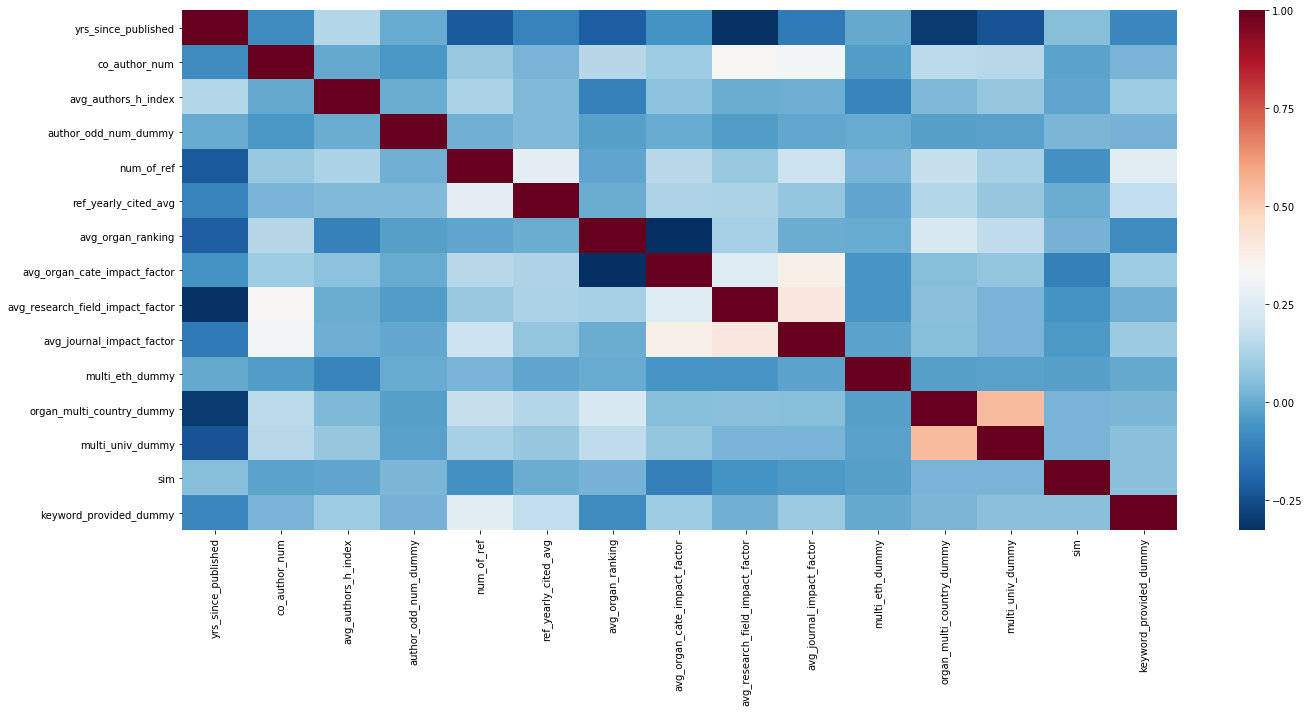

In [257]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_df = X.corr()
sns.heatmap(corr_df, cmap='RdBu_r')
plt.savefig('./graph/image16', bbox_inches='tight')
plt.tight_layout()
plt.show()

## 2. Feature Selection

1. all varaibles group : 15 variables
2. truncated group 1: 13 variables (dropped variables: "avg_organ_cate_impact_factor", "keyword_provided_dummy")
3. truncated group 2: 12 variables (dropeed variables: "avg_organ_cate_impact_factor", "keyword_provided_dummy", "ulti_univ_dummy")

In [248]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [249]:
# adding dep_var to employees_final2
X = final_df.drop(columns = ['log_cited_time_per_yr', 'citation_per_yr', 'log_cited_time', 'cited_time'], axis = 1)
y = final_df['log_cited_time_per_yr']
                                
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [250]:
kfold = KFold(n_splits=20, shuffle=True, random_state=1234)
scoring='neg_mean_squared_error'
n_jobs=-1

model = RandomForestRegressor()
param = {
    'n_estimators': [50, 150, 250, 350, 450, 550, 650],
    'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
}

In [251]:
gridsearch = GridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring=scoring, n_jobs=n_jobs)
grid_result = gridsearch.fit(X_train, y_train)
print("Best neg_mean_squared_error: %f \nParameters %s" % (grid_result.best_score_, grid_result.best_params_))

Best neg_mean_squared_error: -0.377794 
Parameters {'max_features': 6, 'n_estimators': 650}


In [252]:
fine_tuned_scaled_rf = grid_result.best_estimator_
y_train_hat = fine_tuned_scaled_rf.predict(X_train)
y_test_hat = fine_tuned_scaled_rf.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_hat))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_hat))
r2_train = fine_tuned_scaled_rf.score(X_train, y_train)
r2_test = fine_tuned_scaled_rf.score(X_test, y_test)

print("RMSE Train:",rmse_train)
print("RMSE Test:",rmse_test)

print("R^2 Train:",r2_train)
print("R^2 test:",r2_test)

RMSE Train: 0.22781145787633986
RMSE Test: 0.6205571553072751
R^2 Train: 0.9272887746646161
R^2 test: 0.43401002182827353


1 . avg_journal_impact_factor 0.24112909564841725
2 . yrs_since_published 0.16173525642950815
3 . num_of_ref 0.11955501900977286
4 . avg_authors_h_index 0.08611313230213649
5 . ref_yearly_cited_avg 0.08167816468010343
6 . avg_organ_cate_impact_factor 0.06951701150594104
7 . avg_research_field_impact_factor 0.06017186299072728
8 . avg_organ_ranking 0.056165709812776195
9 . sim 0.05433656861887823
10 . co_author_num 0.03833483165084786
11 . author_odd_num_dummy 0.007322818414502013
12 . multi_eth_dummy 0.006789947527292611
13 . keyword_provided_dummy 0.006130829725009883
14 . organ_multi_country_dummy 0.005768399100332087
15 . multi_univ_dummy 0.0052513525837550945


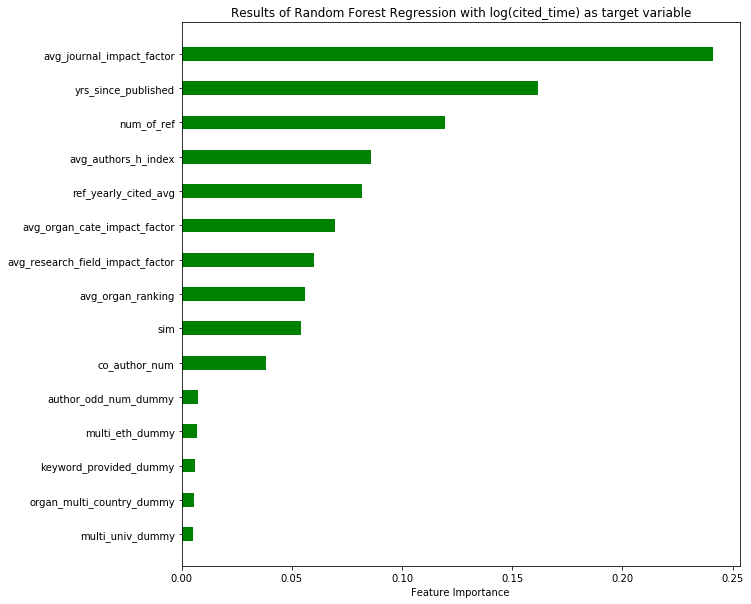

In [260]:
# Sorting features by their score
features, importances = zip(*sorted(zip(list(X.columns), fine_tuned_scaled_rf.feature_importances_), key=lambda x: x[1], reverse=True))

# Printing out the results 
num = 0
for f, i in zip(features, importances):
    num += 1
    print(num,".", f, i)

# Sorting features by their score
features, importances = zip(*sorted(zip(list(X.columns), fine_tuned_scaled_rf.feature_importances_), key=lambda x: x[1]))
    
# Creating pos, a list containing indexes of unknown_by_yr
yPos = range(len(features))
       
plt.rcParams['figure.figsize'] =  (10.0, 10.0)
# Plotting the horizontal bar chart
plt.barh(yPos,  importances,  height = 0.4, color='green') 

# Setting xticks to have the same `pos` as bars 
plt.yticks(yPos, features)

# Setting xlabel
plt.xlabel('Feature Importance')

#  Setting a title, and axes labels
plt.title('Results of Random Forest Regression with log(cited_time) as target variable')
plt.savefig('./graph/image17', bbox_inches='tight')
plt.show()

In [254]:
def remove_all_high_VIF(df, predictors, threshold=10):        
    columns = predictors
    df = df[columns].copy()
    
    dropped = True
    while dropped:
        dropped = False
        vif_vals = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]        
        max_vif = max(vif_vals)
        if max_vif > threshold:
            max_vif_index = vif_vals.index(max_vif)
            print('Dropped:',columns[max_vif_index],max_vif)
            del columns[max_vif_index]
            df = df[columns]
            dropped = True

    predictors = columns
    return predictors

In [255]:
trunc_columns = remove_all_high_VIF(final_df, list(X.columns))
f = final_df[trunc_columns]
print("\n")
print("=== VIF values ===")
count = 0
for i in range(f.shape[1]):
    count +=1
    vif = variance_inflation_factor(f.values, i)
    print(count, ".", f.columns[i],':', vif)

Dropped: avg_organ_cate_impact_factor 15.187799190235713
Dropped: keyword_provided_dummy 12.310769196669753


=== VIF values ===
1 . yrs_since_published : 3.615755624933456
2 . co_author_num : 2.714195154338209
3 . avg_authors_h_index : 3.6188859640492077
4 . author_odd_num_dummy : 1.985901873834904
5 . num_of_ref : 4.117195696175851
6 . ref_yearly_cited_avg : 2.7652310373497286
7 . avg_organ_ranking : 1.874520068769766
8 . avg_research_field_impact_factor : 6.929958302150532
9 . avg_journal_impact_factor : 2.0298099847671316
10 . multi_eth_dummy : 1.2220048819151639
11 . organ_multi_country_dummy : 3.632010302312687
12 . multi_univ_dummy : 5.5411584340029085
13 . sim : 4.649754213091423


In [256]:
# drop multi_univ_dummy due to high correlation
trunc_columns2 = ['yrs_since_published', 'co_author_num', 'avg_authors_h_index', 'author_odd_num_dummy', 'num_of_ref', 'ref_yearly_cited_avg', 'avg_organ_ranking', 'avg_research_field_impact_factor','avg_journal_impact_factor', 'multi_eth_dummy', 'organ_multi_country_dummy', 'sim']
print("Dropped: multi_univ_dummy\n")
print("=== VIF values ===")

f = final_df[trunc_columns2]
count = 0
for i in range(f.shape[1]):
    count +=1
    vif = variance_inflation_factor(f.values, i)
    print(count, ".", f.columns[i],':',vif)

Dropped: multi_univ_dummy

=== VIF values ===
1 . yrs_since_published : 3.602466372183813
2 . co_author_num : 2.6945608780798396
3 . avg_authors_h_index : 3.5515668503424327
4 . author_odd_num_dummy : 1.9818345666816204
5 . num_of_ref : 4.088475659945234
6 . ref_yearly_cited_avg : 2.7636660199697363
7 . avg_organ_ranking : 1.8603261373121118
8 . avg_research_field_impact_factor : 6.8362039709083735
9 . avg_journal_impact_factor : 2.0264496920716795
10 . multi_eth_dummy : 1.2199605426649862
11 . organ_multi_country_dummy : 2.6657469043740902
12 . sim : 4.563517197883156


## 3-1. Model Evaluation (Linear Regression)

In [142]:
# Regression using all variables
from sklearn.metrics import mean_squared_error

# Regression using all variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train = sm.add_constant(X_train) #intercept added
X_test = sm.add_constant(X_test)

# fit the model onto the training sample
model = sm.OLS(y_train, X_train).fit()
y_hat = model.predict(X_test) # make the predictions by the model
rmse_full =  np.sqrt(mean_squared_error(y_test, y_hat))

# Regression using truncated variables (1)
X_train, X_test, y_train, y_test = train_test_split(X[trunc_columns], y, test_size = 0.2, random_state = 123)
X_train = sm.add_constant(X_train) #intercept added
X_test = sm.add_constant(X_test)

model_trunc1 = sm.OLS(y_train, X_train).fit()
y_hat_trunc1 = model_trunc1.predict(X_test) # make the predictions by the model
rmse_trunc1 =  np.sqrt(mean_squared_error(y_test, y_hat_trunc1))

# Regression using truncated variables (2)
X_train, X_test, y_train, y_test = train_test_split(X[trunc_columns2], y, test_size = 0.2, random_state = 123)
X_train = sm.add_constant(X_train) #intercept added
X_test = sm.add_constant(X_test)

model_trunc2 = sm.OLS(y_train, X_train).fit()
y_hat_trunc2 = model_trunc2.predict(X_test) # make the predictions by the model
rmse_trunc2 =  np.sqrt(mean_squared_error(y_test, y_hat_trunc2))


print("=== Full Model Performance in testset ===")
print("Adjusted R2 for the full model is: %s"  %(round(model.rsquared_adj, 5)))
print("RMSE for the full model is: %s\n" %(round(rmse_full, 5)))

print("=== Truncated Model 1 Performance in testset ===")
print("Adjusted R2 for the truncated model is: %s" %(round(model_trunc1.rsquared_adj, 5)))
print("RMSE for the truncated model is: %s\n" %(round(rmse_trunc1, 5)))

print("=== Truncated Model 2 Performance in testset(trunc1+'organ_country_diversity' dropped) ===")
print("Adjusted R2 for the truncated model is: %s" %(round(model_trunc2.rsquared_adj, 5)))
print("RMSE for the truncated model is: %s" %(round(rmse_trunc2, 5)))

=== Full Model Performance in testset ===
Adjusted R2 for the full model is: 0.36439
RMSE for the full model is: 0.65012

=== Truncated Model 1 Performance in testset ===
Adjusted R2 for the truncated model is: 0.35526
RMSE for the truncated model is: 0.65818

=== Truncated Model 2 Performance in testset(trunc1+'organ_country_diversity' dropped) ===
Adjusted R2 for the truncated model is: 0.35348
RMSE for the truncated model is: 0.6606


In [143]:
from statsmodels.iolib.summary2 import summary_col
linear_reg = summary_col([model, model_trunc1, model_trunc2],stars=True)
print(linear_reg)


                                 log_cited_time_per_yr I log_cited_time_per_yr II log_cited_time_per_yr III
-----------------------------------------------------------------------------------------------------------
author_odd_num_dummy             0.0579                  0.0611                   0.0583                   
                                 (0.0473)                (0.0476)                 (0.0477)                 
avg_authors_h_index              0.0091***               0.0093***                0.0096***                
                                 (0.0021)                (0.0021)                 (0.0021)                 
avg_journal_impact_factor        0.0707***               0.0798***                0.0795***                
                                 (0.0092)                (0.0087)                 (0.0087)                 
avg_organ_cate_impact_factor     0.1642***                                                                 
                           

### 3-2. Negative Binomial Regression

In [261]:
NB_reg = smf.glm(formula = "citation_per_yr ~ yrs_since_published + co_author_num + avg_authors_h_index + author_odd_num_dummy + num_of_ref + ref_yearly_cited_avg + avg_organ_ranking + avg_research_field_impact_factor + avg_journal_impact_factor + multi_eth_dummy + organ_multi_country_dummy+sim", data=final_df, family=sm.families.NegativeBinomial()).fit()

## 3-3. Model Interpretation

In [264]:
NB_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        citation_per_yr   No. Observations:                 1072
Model:                            GLM   Df Residuals:                     1059
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    log   Scale:              0.8971217859440372
Method:                          IRLS   Log-Likelihood:                -2506.6
Date:                Sun, 22 Jul 2018   Deviance:                       792.54
Time:                        22:55:54   Pearson chi2:                     950.
No. Iterations:                    44                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.1497      0.189     -6.087      0.000      -1.520      -0.780
yrs_since_published                  0.0845      0.008     10.849      0.000       0.069       0.100
co_author_num                        0.0428      0.011      3.852      0.000       0.021       0.065
avg_authors_h_index                  0.0126      0.003      4.328      0.000       0.007       0.018
author_odd_num_dummy                 0.0214      0.068      0.317      0.751      -0.111       0.154
num_of_ref                           0.0101      0.001      8.733      0.000       0.008       0.012
ref_yearly_cited_avg                 0.0116      0.002      5.491      0.000       0.007       0.016
avg_organ_ranking                   -0.0008      0.000     -4.259      0.000      -0.001      -0.000
avg_research_field_impact_factor     0.0976      0.057      1.709      0.087      -0.014       0.210
avg_journal_impact_factor            0.1077      0.010     10.308      0.000       0.087       0.128
multi_eth_dummy                      0.1451      0.087      1.663      0.096      -0.026       0.316
organ_multi_country_dummy            0.1747      0.075      2.339      0.019       0.028       0.321
sim                                  0.2324      0.642      0.362      0.717      -1.026       1.490
====================================================================================================
"""

## NB Regression vs. Poisson Regression (Similar Result)

In [ ]:
from statsmodels.iolib.summary2 import summary_col
Poisson_reg = smf.glm(formula = "citation_per_yr ~ yrs_since_published + co_author_num + avg_authors_h_index + author_odd_num_dummy + num_of_ref + ref_yearly_cited_avg + avg_organ_ranking + avg_research_field_impact_factor + avg_journal_impact_factor + multi_eth_dummy + organ_multi_country_dummy+sim", data=final_df, family=sm.families.Poisson()).fit()
NB_Poisson = summary_col([NB_reg, Poisson_reg],stars=True)
print("          cited_time I(NB Regression)     vs.     cited_time II(Poisson Regression)")
print(NB_Poisson)